In [2]:
import numpy as np 
import pandas as pd

import sys
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re

from gensim.models import Phrases
from gensim.models.phrases import Phraser

D:\conda\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_excel('D:\pythonProject\hotel_review\\review.xls')
data.head()

,Name,Review,Time,Trip_type,Rating,Value,Rooms,Location,Cleanliness,Service,Sleep Quality
0,Aloha808bc,"Easy check in and out, great location of cours...",2022-12-3,BUSINESS,5,5,5,5,5,5,5
1,Adeepr,"We stayed here many times, mainly after arriva...",2022-11-3,NONE,5,5,3,5,5,3,5
2,hberthelsen,The Hotel does its purpose - transit hotel for...,2022-11-3,BUSINESS,3,3,3,5,2,3,3
3,Storyteller311474,We usually love to stay in this hotel because ...,2022-11-3,NONE,2,1,1,4,1,2,3
4,ninav992022,"Very quiet, neat and the equipments are all go...",2022-11-3,NONE,4,4,4,5,4,5,5


In [ ]:
import seaborn as sns
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())
sns.set_style(style="darkgrid")
sns.distplot(data['length'])

Mean length:  108.15534979423869


D:\conda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


In [4]:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [5]:
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return  trigrams_text

In [6]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [7]:
tokens_reviews = make_n_grams(tokens_reviews)

In [8]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts

def remove_stopwords(texts, stop_list):

    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(stop_list))] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
stop_list = [word.strip() for word in
                 open(r'D:\pythonProject\hotel_review\stopword.txt', 'r', encoding='utf-8').readlines()]
reviews_lemmatized = remove_stopwords(reviews_lemmatized, stop_list)


In [10]:
data['clear_word'] = data['review_list']
for i, lines in enumerate(reviews_lemmatized):
    data['clear_word'][i] = " ".join(lines)
print(data['clear_word'][1])

D:\conda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


stay time mainly arrival departure location time expect standard hit bar restaurant operation provision room extremely enjoy night stay fly home room sleep week visit restaurant surprise food definitely


In [11]:
np.random.seed(0)


In [12]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 4412 clusters with 6 clusters populated
In stage 1: transferred 2832 clusters with 6 clusters populated
In stage 2: transferred 1784 clusters with 6 clusters populated
In stage 3: transferred 1293 clusters with 6 clusters populated
In stage 4: transferred 1042 clusters with 6 clusters populated
In stage 5: transferred 841 clusters with 6 clusters populated
In stage 6: transferred 769 clusters with 6 clusters populated
In stage 7: transferred 696 clusters with 6 clusters populated
In stage 8: transferred 621 clusters with 6 clusters populated
In stage 9: transferred 569 clusters with 6 clusters populated
In stage 10: transferred 541 clusters with 6 clusters populated
In stage 11: transferred 554 clusters with 6 clusters populated
In stage 12: transferred 482 clusters with 6 clusters populated
In stage 13: transferred 466 clusters with 6 clusters populated
In stage 14: transferred 482 clusters with 6 clusters populated
In stage 15: transferred 459 clusters with 6 

In [13]:
def top_words(cluster_word_distribution, top_cluster, values):
    topic_words = []
    i = 0
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))
        topic_words.append(sort_dicts)
    return topic_words

In [14]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
sort_dicts = top_words(mgp.cluster_word_distribution, top_index, 15)

# top_words(mgp.cluster_word_distribution, 15)

Number of documents per topic : [  34    9   10  486 2132 3161]

Most important clusters (by number of docs inside): [5 4 3 0 2 1]

Cluster 5 : [('room', 6313), ('hotel', 5965), ('airport', 2963), ('stay', 2945), ('check', 2316), ('time', 1457), ('staff', 1427), ('flight', 1235), ('service', 1157), ('night', 1144), ('need', 1094), ('day', 1081), ('food', 986), ('bed', 927), ('walk', 922)]

Cluster 4 : [('hotel', 3256), ('room', 2457), ('airport', 2337), ('stay', 1884), ('check', 967), ('flight', 935), ('walk', 881), ('staff', 748), ('night', 715), ('service', 523), ('restaurant', 519), ('day', 518), ('time', 514), ('breakfast', 510), ('hour', 481)]

Cluster 3 : [('hotel', 650), ('stay', 478), ('staff', 364), ('service', 285), ('room', 268), ('airport', 242), ('lounge', 168), ('check', 143), ('time', 139), ('club', 110), ('help', 106), ('food', 83), ('come', 76), ('experience', 76), ('family', 73)]

Cluster 0 : [('hotel', 46), ('airport', 26), ('room', 23), ('stay', 20), ('flight', 19),

In [15]:
topic_words = []
for dic in sort_dicts:
    for item in dic:
        topic_words.append(item[0])
print(set(topic_words),len(set(topic_words)))

{'hotel', 'dbu_ebu', 'airport', 'room', 'transit', 'experience', 'people', 'exhibition', 'breakfast', 'help', 'check', 'club', 'place', 'flight', 'facility', 'walk', 'lounge', 'concierge', 'guest', 'lady', 'service', 'family', 'restaurant', 'staff', 'come', 'appreciate', 'night', 'feel', 'need', 'hour', 'location', 'soon', 'connection', 'minute', 'hear', 'time', 'later', 'stay', 'food', 'reception', 'wifi', 'front_desk', 'bed', 'day'} 44


In [18]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 
    

def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(6)

,Text,Topic,Rating,Lemma-text
0,"Easy check in and out, great location of cours...",type 2,5,"[check, location, course, nbeen, time, prior, ..."
1,"We stayed here many times, mainly after arriva...",type 2,5,"[stay, time, mainly, arrival, departure, locat..."
2,The Hotel does its purpose - transit hotel for...,type 1,3,"[hotel, purpose, transit, hotel, night, condit..."
3,We usually love to stay in this hotel because ...,type 1,2,"[usually, love, stay, hotel, convenience, stay..."
4,"Very quiet, neat and the equipments are all go...",type 1,4,"[neat, equipment, enjoy, table, room, space, n..."
5,Stayed 3 days while waiting for another flight...,type 1,4,"[stay, day, wait, flight, meal, day, deliver, ..."


# 词云绘制

In [19]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 
    wordcloud.to_file('词云.png')
    


In [20]:
counts = {}
for words in reviews_lemmatized:
    for word in words:
        if len(word) == 1:
            continue
        else:
            rword = word
        counts[rword] = counts.get(rword,0) + 1 
items = list(counts.items())
items.sort(key=lambda x:x[1], reverse=True)



In [21]:
import xlwt
wb = xlwt.Workbook(encoding="utf-8", style_compression=0)  # 创建workbook对象
ws = wb.add_sheet("词频统计", cell_overwrite_ok=True)  # 创建工作表
col = ["词", "数量"]
for i in range(0, 2):
    ws.write(0, i, col[i])
for j in range(len(items)):
    ws.write(j + 1, 0, items[j][0])
    ws.write(j + 1, 1, items[j][1])
wb.save(".\\词频统计.xls")

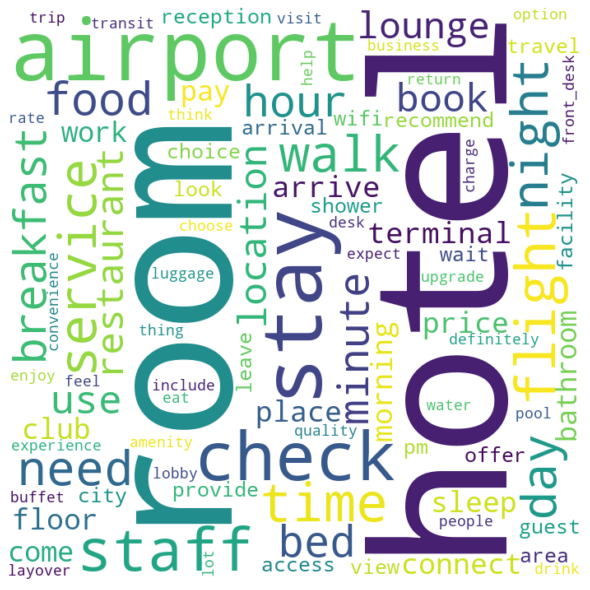

In [22]:
# result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))
# result = result.drop('Lemma-text', axis=1)
# data['clear_word'] .values
# create_WordCloud(data['clear_word'] )
# mask = np.array(Image.open('chinamap.jpg')) # 导入词频背景图片
#设置词云图片的参数
w = WordCloud(
    width = 700, height = 700,
    background_color = "white",
    min_font_size = 15,
    max_words = 100)
w.generate_from_frequencies(counts)  #以词云生成词云
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(w, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
w.to_file("grwordcloud.png")    #保存词云图片 


In [17]:
import torch
import torchtext.vocab as vocab

# vocab.pretrained_aliases.keys()

In [18]:
cache_dir = "E:/word embedding/glove"
glove = vocab.pretrained_aliases["glove.twitter.27B.100d"](cache=cache_dir)
# glove = vocab.GloVe(name='twitter.27B', dim=100, cache=cache_dir) # 与上面等价

In [19]:
def knn(W, x, k):
    # 添加的1e-9是为了数值稳定性
    cos = torch.matmul(W, x.view((-1,))) / (
        (torch.sum(W * W, dim=1) + 1e-9).sqrt() * torch.sum(x * x).sqrt())
    _, topk = torch.topk(cos, k=k)
    topk = topk.cpu().numpy()
    return topk, [cos[i].item() for i in topk]

In [91]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.vectors,
                    embed.vectors[embed.stoi[query_token]], k+1)
    word = []
    for i, c in zip(topk[1:], cos[1:]):  # 除去输入词
#         print('cosine sim=%.3f: %s' % (c, (embed.itos[i])))
        word.append(embed.itos[i])
    return word


In [96]:
top = get_similar_tokens('clean', 50, glove)
top

['wash',
 'shower',
 'wet',
 'cleaning',
 'dirty',
 'room',
 'fresh',
 'bath',
 'laundry',
 'washing',
 'bathroom',
 'clothes',
 'cleaned',
 'kitchen',
 'sheets',
 'work',
 'brush',
 'put',
 'lazy',
 'better',
 'paint',
 'leave',
 'enough',
 'dry',
 'water',
 'out',
 'turn',
 'tidy',
 'take',
 'up',
 'washed',
 'dishes',
 'get',
 'before',
 'then',
 'smell',
 'cut',
 'bedroom',
 'body',
 'throw',
 'need',
 'home',
 'easy',
 'sit',
 'gotta',
 'head',
 'mess',
 'whip',
 'trying',
 'clear']

In [121]:
word_fre = pd.read_excel('D:\jupyter\词频统计.xls')
print(word_fre)

                词    数量
0           hotel  8511
1            room  8021
2         airport  4894
3            stay  4629
4           check  3130
...           ...   ...
6724  conveniance     1
6725      sticker     1
6726        steer     1
6727  coincidence     1
6728       tailor     1

[6729 rows x 2 columns]


In [61]:
sum(word_fre['数量'][:1000])/sum(word_fre['数量'])

0.8902911447963513

In [103]:
seed = ['value', 'lounge', 'room', 'space', 'airport', 'location', 'clean', 'towel', 'staff', 'service','sleep','quiet']
seed_words = {}
pote = []
[pote.append(word) for word in word_fre['词'][:1000]]
for i, seed_word in enumerate(seed):
    top = get_similar_tokens(seed_word, 50, glove)
    seed_words[i] =[]
    for word in top:
        if word in pote:
            seed_words[i].append(word)


In [106]:
top = get_similar_tokens('cash', 50, glove)
top

['money',
 'pay',
 'credit',
 'paid',
 'dollar',
 'dollars',
 'free',
 'deposit',
 'card',
 'tax',
 'paying',
 'earn',
 'sell',
 'buy',
 'bonus',
 'payday',
 'loan',
 'offer',
 'ticket',
 'rich',
 'bills',
 'payments',
 'loans',
 'cards',
 'cost',
 'refund',
 'payment',
 'get',
 'savings',
 'business',
 'bucks',
 'drop',
 'save',
 'fee',
 'worth',
 'million',
 'selling',
 'taxes',
 'check',
 'debt',
 'exchange',
 'charge',
 'spend',
 'cent',
 'give',
 'cents',
 'purchase',
 'bank',
 'deal',
 'low']

In [181]:
f = open("E:/论文6/word.txt",'r')
count = [ ]
for line in f:
    num = 0
    for word in line.split(','):
        num = (word_fre.query(f'词 ==["{word.strip()}"]')['数量']) + num
#         print(int(word_fre.query(f'词 ==["{word.strip()}"]')['数量']))
    count.append(num)
count

[30     NaN
 38     NaN
 123    NaN
 138    NaN
 144    NaN
 212    NaN
 415    NaN
 435    NaN
 459    NaN
 524    NaN
 625    NaN
 730    NaN
 912    NaN
 928    NaN
 1859   NaN
 2138   NaN
 Name: 数量, dtype: float64,
 1     NaN
 13    NaN
 37    NaN
 39    NaN
 43    NaN
 48    NaN
 78    NaN
 90    NaN
 111   NaN
 135   NaN
 141   NaN
 143   NaN
 158   NaN
 194   NaN
 195   NaN
 222   NaN
 250   NaN
 280   NaN
 294   NaN
 319   NaN
 423   NaN
 448   NaN
 464   NaN
 522   NaN
 523   NaN
 526   NaN
 595   NaN
 640   NaN
 641   NaN
 701   NaN
 727   NaN
 728   NaN
 749   NaN
 752   NaN
 781   NaN
 824   NaN
 836   NaN
 839   NaN
 847   NaN
 888   NaN
 930   NaN
 931   NaN
 936   NaN
 939   NaN
 943   NaN
 Name: 数量, dtype: float64,
 2     NaN
 18    NaN
 26    NaN
 94    NaN
 110   NaN
 234   NaN
 240   NaN
 339   NaN
 359   NaN
 455   NaN
 463   NaN
 554   NaN
 682   NaN
 709   NaN
 831   NaN
 Name: 数量, dtype: float64,
 34     NaN
 137    NaN
 192    NaN
 279    NaN
 291    NaN
 314   

In [136]:
word_fre.query('词 ==["value"]')['数量']

203